# Variational Autoencoder (VAE) - Gesichtsgenerierung mit CelebA Dataset

In diesem Notebook wird ein Variational Autoencoder (VAE) auf dem CelebA-Datensatz trainiert, um realistische Gesichtsbilder zu generieren.


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [19]:
# MPS (Metal Performance Shaders) Unterstützung prüfen
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ MPS (Apple GPU) wird verwendet!")
else:
    device = torch.device("cpu")
    print("⚠️  MPS nicht verfügbar, CPU wird verwendet.")

✅ MPS (Apple GPU) wird verwendet!


In [20]:
# Import CelebA-data via Kagglehub API
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Path to dataset files:", path)

Path to dataset files: /Users/julian/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [21]:
# Hyperparameters
batch_size = 128
image_size = 64

# Transformationen: Bilder auf 64x64 skalieren, normalisieren
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# DataLoader Setup
dataset = datasets.ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Testausgabe: Batch anzeigen
dataiter = iter(dataloader)
images, labels = next(dataiter)
print(f"Batch Size: {images.size()}")

Batch Size: torch.Size([128, 3, 64, 64])


In [22]:
class VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [23]:
# Modell instanziieren und Optimizer definieren
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

print("✅ Model and optimizer are ready.")

✅ Model and optimizer are ready.


In [24]:
# Verlustfunktionen: Rekonstruktionsverlust (MSE) + KL-Divergenz
def loss_function(recon_x, x, mu, logvar):
    # Rekonstruktionsverlust (Mean Squared Error)
    reconstruction_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    
    # KL-Divergenz
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Gesamtverlust
    return reconstruction_loss + kl_divergence

In [25]:
import os

# Sicherstellen, dass der Pfad existiert
os.makedirs("model_checkpoints", exist_ok=True)

# Hyperparameter für das Training
print_interval = 500
evaluation_interval = 1000
patience = 5
min_delta = 1e-4
best_loss = float('inf')
patience_counter = 0

# Training Loop mit Early Stopping und Modell-Speicherung
vae.train()
step = 0
epoch_counter = 0

while patience_counter < patience:
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward Pass
        recon_batch, mu, logvar = vae(data)
        
        # Verlust berechnen und Backpropagation
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        
        # Optimierungsschritt
        optimizer.step()
        step += 1
        
        # Ausgabe alle 500 Schritte
        if step % print_interval == 0:
            print(f"✅ Step [{step}] - Loss: {loss.item():.4f}")
        
        # Überprüfung alle 1000 Schritte
        if step % evaluation_interval == 0:
            average_loss = total_loss / evaluation_interval
            print(f"\n🔍 Evaluation nach {step} Schritten: Average Loss: {average_loss:.4f}")
            
            # Early Stopping Check und Modell speichern
            if average_loss < best_loss - min_delta:
                best_loss = average_loss
                patience_counter = 0
                # Modell speichern
                model_path = f"model_checkpoints/vae_best_step_{step}.pt"
                torch.save(vae.state_dict(), model_path)
                print(f"💾 Modell verbessert und gespeichert unter: {model_path}")
            else:
                patience_counter += 1
                print(f"⚠️ Keine Verbesserung. Patience Counter: {patience_counter}/{patience}")
            
            # Reset des total_loss für die nächste Evaluation
            total_loss = 0

        # Training abbrechen, wenn die Patience überschritten wird
        if patience_counter >= patience:
            break

print(f"\n✅ Training abgeschlossen nach {step} Schritten.")
print(f"📌 Bestes Modell gespeichert unter: {model_path}")

✅ Step [500] - Loss: 84240.8438
✅ Step [1000] - Loss: 76842.2031

🔍 Evaluation nach 1000 Schritten: Average Loss: 115377.6877
💾 Modell verbessert und gespeichert unter: model_checkpoints/vae_best_step_1000.pt
✅ Step [1500] - Loss: 70303.2031
✅ Step [2000] - Loss: 68577.5156

🔍 Evaluation nach 2000 Schritten: Average Loss: 28222.2659
💾 Modell verbessert und gespeichert unter: model_checkpoints/vae_best_step_2000.pt
✅ Step [2500] - Loss: 63437.4141
✅ Step [3000] - Loss: 62990.8750

🔍 Evaluation nach 3000 Schritten: Average Loss: 65177.2555
⚠️ Keine Verbesserung. Patience Counter: 1/5
✅ Step [3500] - Loss: 61855.9844
✅ Step [4000] - Loss: 63311.9453

🔍 Evaluation nach 4000 Schritten: Average Loss: 52124.8658
⚠️ Keine Verbesserung. Patience Counter: 2/5
✅ Step [4500] - Loss: 62129.9219
✅ Step [5000] - Loss: 61026.9805

🔍 Evaluation nach 5000 Schritten: Average Loss: 15304.3946
💾 Modell verbessert und gespeichert unter: model_checkpoints/vae_best_step_5000.pt
✅ Step [5500] - Loss: 59898.632

In [29]:
print(f"Lade das beste Modell vom Training: {model_path}")
vae.load_state_dict(torch.load(model_path, map_location=device))
vae.eval()

# Neuen DataLoader für Visualisierung erzeugen
visualization_loader = DataLoader(dataset, batch_size=512, shuffle=True)

# Latente Vektoren und Labels sammeln
latent_vectors = []
image_samples = []

# Durch den DataLoader iterieren
for batch_idx, (data, _) in enumerate(visualization_loader):
    data = data.to(device)
    with torch.no_grad():
        _, mu, _ = vae(data)
        latent_vectors.append(mu.cpu().numpy())
        image_samples.append(data.cpu().numpy())
    
    # Maximal 5000 Samples anzeigen, um Übersicht zu behalten
    if len(latent_vectors) * 512 >= 5000:
        break

# In ein numpy Array konvertieren
latent_vectors = np.concatenate(latent_vectors, axis=0)
image_samples = np.concatenate(image_samples, axis=0)
print(f"Latente Dimensionen gesammelt: {latent_vectors.shape}")

Lade das beste Modell vom Training: model_checkpoints/vae_best_step_8000.pt
Latente Dimensionen gesammelt: (5120, 100)


🔄 Reduziere die Dimensionen für Visualisierung...


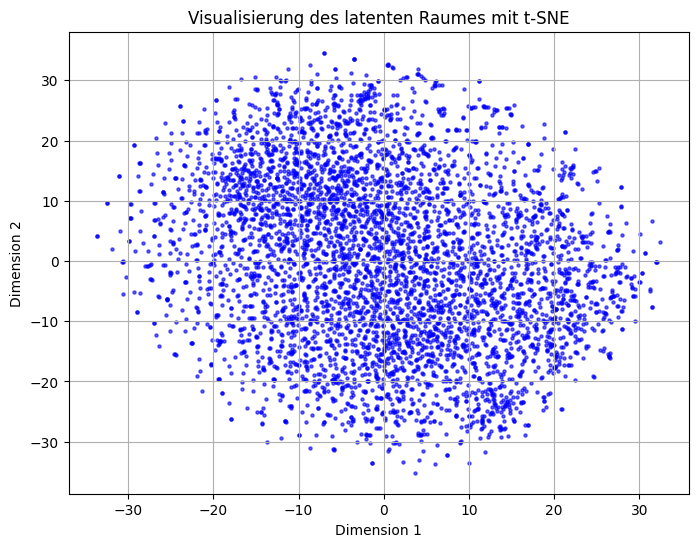

In [30]:
# Reduzierung der Dimensionalität auf 2D mit t-SNE
print("🔄 Reduziere die Dimensionen für Visualisierung...")
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

# Visualisierung
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=5, alpha=0.6, color='blue')
plt.title("Visualisierung des latenten Raumes mit t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

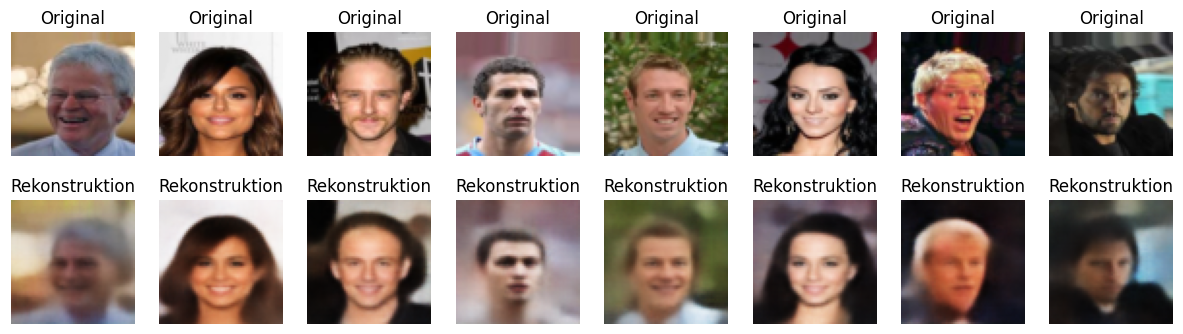

In [57]:
# Modell in Evaluierungsmodus setzen
vae.eval()

# Ein Batch aus dem DataLoader holen
dataiter = iter(dataloader)
images, _ = next(dataiter)
images = images.to(device)

# Rekonstruktion durch das Modell
with torch.no_grad():
    reconstructed, _, _ = vae(images)

# Anzahl der anzuzeigenden Bilder (maximal 8, damit es übersichtlich bleibt)
num_images = min(8, images.size(0))

# Darstellung der Originalbilder und der Rekonstruktionen
fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

for i in range(num_images):
    # Originale Bilder
    axes[0, i].imshow(np.transpose(images[i].cpu(), (1, 2, 0)) * 0.5 + 0.5)
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    # Rekonstruierte Bilder
    axes[1, i].imshow(np.transpose(reconstructed[i].cpu(), (1, 2, 0)) * 0.5 + 0.5)
    axes[1, i].set_title("Rekonstruktion")
    axes[1, i].axis('off')

plt.show()

In [58]:
# Anzahl der Bilder, die wir generieren wollen
num_samples = 16

# Sampling aus dem latenten Raum
print(f"🔄 Erzeuge {num_samples} neue Samples aus dem latenten Raum...")
with torch.no_grad():
    # Normalverteilung im latenten Raum (0, 1) für Sampling
    sampled_latents = torch.randn(num_samples, 100).to(device)
    generated_images = vae.decoder(sampled_latents).cpu()

🔄 Erzeuge 16 neue Samples aus dem latenten Raum...


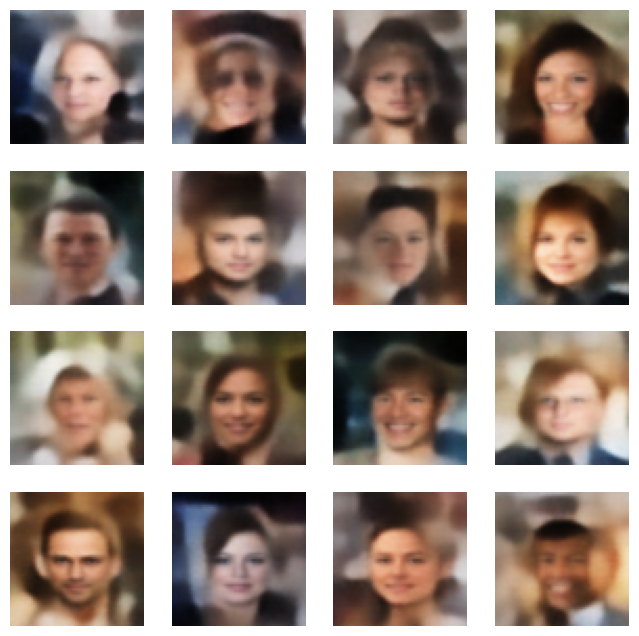

In [59]:
# Darstellung der generierten Bilder
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(generated_images[i], (1, 2, 0)) * 0.5 + 0.5)
    ax.axis('off')
plt.show()